In [1]:
import pdb
import os
from pathlib import Path
import pandas as pd
import numpy as np
import random
import sys
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss
from stargazer.stargazer import Stargazer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from plotnine import *

In [287]:
# Import the prewritten helper functions 
from py_helper_functions import *

In [2]:
path = Path(os.getcwd())
base_dir = path.parent.parent

In [3]:
#Windows format
data_in = os.path.join(str(base_dir) , "da_data_repo\\bisnode-firms\\clean\\")
data_out = os.path.join(str(base_dir) , "da_data_repo\\bisnode-firms\\")
output = os.path.join(data_out,'output')
func = os.path.join(str(base_dir) ,   "da_case_studies\\ch00-tech-prep\\")

In [4]:
current_csv_path = os.path.join(data_out,"bisnode_firms_clean.csv")
data = pd.read_csv(current_csv_path)

In [5]:
# Define variable sets ----------------------------------------------
# (making sure we use categories)
data['urban_m'] = data['urban_m'].astype("category")
data['ind2_cat'] = data['ind2_cat'].astype("category")
data['m_region_loc'] = data['region_m'].astype("category")

rawvars = ["curr_assets", "curr_liab", "extra_exp", "extra_inc", "extra_profit_loss", "fixed_assets",
              "inc_bef_tax", "intang_assets", "inventories", "liq_assets", "material_exp", "personnel_exp",
              "profit_loss_year", "sales", "share_eq", "subscribed_cap"]
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = ["total_assets_bs", "fixed_assets_bs", "liq_assets_bs", "curr_assets_bs",
            "share_eq_bs", "subscribed_cap_bs", "intang_assets_bs", "extra_exp_pl",
            "extra_inc_pl", "extra_profit_loss_pl", "inc_bef_tax_pl", "inventories_pl",
            "material_exp_pl", "profit_loss_year_pl", "personnel_exp_pl"]
engvar2 = ["extra_profit_loss_pl_quad", "inc_bef_tax_pl_quad",
             "profit_loss_year_pl_quad", "share_eq_bs_quad"]
engvar3=[]
for col in data.columns:
    if col.endswith('flag_low') or col.endswith('flag_high') or col.endswith('flag_error') or col.endswith('flag_zero'):
        engvar3.append(col)


d1 =  ["d1_sales_mil_log_mod", "d1_sales_mil_log_mod_sq",
         "flag_low_d1_sales_mil_log", "flag_high_d1_sales_mil_log"]
hr = ["female", "ceo_age", "flag_high_ceo_age", "flag_low_ceo_age",
        "flag_miss_ceo_age", "ceo_count", "labor_avg_mod",
        "flag_miss_labor_avg", "foreign_management"]

In [6]:
#Creat dummy columns from category variables and drop first level
ind2_catmat = patsy.dmatrix("0 + C(ind2_cat)",data, return_type="dataframe")
ind2_catmat = ind2_catmat.drop(['C(ind2_cat)[26.0]'], axis=1)
m_region_locmat = patsy.dmatrix("0 + C(m_region_loc)",data, return_type="dataframe")
m_region_locmat = m_region_locmat.drop(['C(m_region_loc)[Central]'], axis=1)
urban_mmat = patsy.dmatrix("0 + C(urban_m)",data, return_type="dataframe")
urban_mmat = urban_mmat.drop(['C(urban_m)[1.0]'], axis=1)

In [7]:
basevars = data[["sales_mil_log", "sales_mil_log_sq", "d1_sales_mil_log_mod", "profit_loss_year_pl"]]
# Define X1
X1 = pd.concat([basevars, ind2_catmat], axis=1)
# Define X2
X2additional_vars = data[["fixed_assets_bs", "share_eq_bs","curr_liab_bs", "curr_liab_bs_flag_high", \
                          "curr_liab_bs_flag_error",  "age", "foreign_management"]]
X2 = pd.concat([X1, X2additional_vars], axis=1)
# Define X3
firm = pd.concat([data[["age", "age2", "new"]], ind2_catmat, m_region_locmat,urban_mmat], axis=1)
X3 = pd.concat([data[["sales_mil_log", "sales_mil_log_sq"] + engvar + d1], firm], axis=1)
# Define X4
X4 = pd.concat([data[["sales_mil_log", "sales_mil_log_sq"] + engvar + d1 \
                                 + engvar2 + engvar3 + hr + qualityvars], firm], axis=1)

In [8]:
# Define X5
#Creat matrix for interactions1 variables
int1mat = patsy.dmatrix("0 + C(ind2_cat):age + C(ind2_cat):age2 + C(ind2_cat):d1_sales_mil_log_mod \
                + C(ind2_cat):sales_mil_log + C(ind2_cat):ceo_age + C(ind2_cat):foreign_management \
                + C(ind2_cat):female + C(ind2_cat):C(urban_m) + C(ind2_cat):labor_avg_mod", data, return_type="dataframe")
#Drop first level to get k-1 dummies out of k categorical levels 
for col in int1mat.columns:
    if col.startswith('C(ind2_cat)[26.0]') or col.endswith('C(urban_m)[1.0]'):
        int1mat = int1mat.drop([col], axis=1)
        
#Creat matrix for interactions2 variables        
int2mat = patsy.dmatrix("0 + sales_mil_log:age + sales_mil_log:female + sales_mil_log:profit_loss_year_pl \
                + sales_mil_log:foreign_management", data, return_type="dataframe")
X5 = pd.concat([X4, int1mat, int2mat], axis=1)

In [9]:
# Define logitvars for LASSO
logitvars = pd.concat([X4, int1mat, int2mat], axis=1)

In [10]:
# Define rfvars for RF (no interactions, no modified features)
rfvars  = pd.concat([data[["sales_mil", "d1_sales_mil_log"] + rawvars + hr + qualityvars], firm], axis=1)

In [11]:
y = data['default']

In [12]:
import sklearn.metrics as metrics
def regression_results(reg,y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('Intercept:',reg.intercept_)
    #print('Coefficients:', reg.coef_)
    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [13]:
# Check simplest model X1
ols_modelx1 = LinearRegression().fit(X1, y)
regression_results(ols_modelx1, y, ols_modelx1.predict(X1))
print (pd.concat([pd.DataFrame(X1.columns),pd.DataFrame(np.transpose(ols_modelx1.coef_))], axis = 1))

Intercept: 0.018155308163654543
explained_variance:  0.1204
r2:  0.1204
MAE:  0.2852
MSE:  0.1419
RMSE:  0.3766
                       0         0
0          sales_mil_log -0.007481
1       sales_mil_log_sq  0.005824
2   d1_sales_mil_log_mod -0.056779
3    profit_loss_year_pl -0.169230
4      C(ind2_cat)[27.0]  0.019950
5      C(ind2_cat)[28.0]  0.012457
6      C(ind2_cat)[29.0]  0.049450
7      C(ind2_cat)[30.0]  0.001055
8      C(ind2_cat)[33.0]  0.001636
9      C(ind2_cat)[55.0] -0.004769
10     C(ind2_cat)[56.0]  0.105632


In [14]:
glm_modelx1 = LogisticRegression(solver="newton-cg",max_iter=1000, penalty="none").fit(X1, y)
regression_results(glm_modelx1, y, glm_modelx1.predict(X1))
print (pd.concat([pd.DataFrame(X1.columns),pd.DataFrame(np.transpose(glm_modelx1.coef_))], axis = 1))

Intercept: [-3.23027285]
explained_variance:  -0.0601
r2:  -0.1993
MAE:  0.1934
MSE:  0.1934
RMSE:  0.4398
                       0         0
0          sales_mil_log -0.323186
1       sales_mil_log_sq -0.001676
2   d1_sales_mil_log_mod -0.366168
3    profit_loss_year_pl -0.858115
4      C(ind2_cat)[27.0]  0.168237
5      C(ind2_cat)[28.0]  0.066164
6      C(ind2_cat)[29.0]  0.515958
7      C(ind2_cat)[30.0]  0.017364
8      C(ind2_cat)[33.0] -0.002646
9      C(ind2_cat)[55.0]  0.039307
10     C(ind2_cat)[56.0]  0.843962


In [15]:
# Check model X2
glm_modelx2 = LogisticRegression(solver="newton-cg", max_iter=1000, penalty="none").fit(X2, y)
regression_results(glm_modelx2, y, glm_modelx2.predict(X2))
print (pd.concat([pd.DataFrame(X2.columns),pd.DataFrame(np.transpose(glm_modelx2.coef_))], axis = 1))

Intercept: [-2.35056904]
explained_variance:  -0.0527
r2:  -0.1592
MAE:  0.187
MSE:  0.187
RMSE:  0.4324
                          0         0
0             sales_mil_log -0.180310
1          sales_mil_log_sq  0.015300
2      d1_sales_mil_log_mod -0.482108
3       profit_loss_year_pl -0.450082
4         C(ind2_cat)[27.0]  0.145493
5         C(ind2_cat)[28.0]  0.032691
6         C(ind2_cat)[29.0]  0.406298
7         C(ind2_cat)[30.0] -0.033016
8         C(ind2_cat)[33.0] -0.157819
9         C(ind2_cat)[55.0]  0.128748
10        C(ind2_cat)[56.0]  0.463619
11          fixed_assets_bs -0.811012
12              share_eq_bs -0.388092
13             curr_liab_bs  0.171157
14   curr_liab_bs_flag_high  0.135359
15  curr_liab_bs_flag_error  0.318083
16                      age -0.035304
17       foreign_management  0.215923


In [16]:
mx2 = sm.Logit(y,sm.add_constant(X2)).fit().get_margeff()
print(mx2.summary())

Optimization terminated successfully.
         Current function value: 0.423258
         Iterations 7
        Logit Marginal Effects       
Dep. Variable:                default
Method:                          dydx
At:                           overall
                             dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
sales_mil_log              -0.0242      0.006     -4.015      0.000      -0.036      -0.012
sales_mil_log_sq            0.0021      0.001      2.464      0.014       0.000       0.004
d1_sales_mil_log_mod       -0.0646      0.005    -12.868      0.000      -0.074      -0.055
profit_loss_year_pl        -0.0603      0.008     -7.740      0.000      -0.076      -0.045
C(ind2_cat)[27.0]           0.0195      0.024      0.829      0.407      -0.027       0.066
C(ind2_cat)[28.0]           0.0044      0.018      0.238      0.812      -0.032       0.040
C(ind2_cat

In [17]:
# baseline model is X4 (all vars, but no interactions) -------------------------------------------------------
ols_model = LinearRegression().fit(X4, y)
regression_results(ols_model, y, ols_model.predict(X4))
print (pd.DataFrame({'Features': X4.columns, 'Coeff': ols_model.coef_}))

Intercept: 0.18397884210964152
explained_variance:  0.1924
r2:  0.1924
MAE:  0.2646
MSE:  0.1303
RMSE:  0.3609
                 Features         Coeff
0           sales_mil_log  3.937242e-03
1        sales_mil_log_sq  3.264151e-03
2         total_assets_bs  5.475821e-10
3         fixed_assets_bs -1.360564e-01
4           liq_assets_bs -1.602016e-02
..                    ...           ...
74      C(ind2_cat)[56.0]  5.406954e-02
75  C(m_region_loc)[East]  1.015797e-02
76  C(m_region_loc)[West] -1.783071e-02
77        C(urban_m)[2.0]  8.293544e-03
78        C(urban_m)[3.0] -9.986761e-04

[79 rows x 2 columns]


In [18]:
glm_model = LogisticRegression(solver="newton-cg",max_iter=1000, penalty="none").fit(X4, y)
regression_results(glm_model, y, glm_model.predict(X4))
print (pd.concat([pd.DataFrame(X4.columns),pd.DataFrame(np.transpose(glm_model.coef_))], axis = 1))

C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\opti

Intercept: [-2.41269162]
explained_variance:  -0.038
r2:  -0.1205
MAE:  0.1807
MSE:  0.1807
RMSE:  0.4251
                        0             0
0           sales_mil_log -2.065526e-01
1        sales_mil_log_sq -3.902705e-03
2         total_assets_bs  7.326026e-09
3         fixed_assets_bs -5.993993e-01
4           liq_assets_bs -1.115235e-01
..                    ...           ...
74      C(ind2_cat)[56.0]  4.661485e-01
75  C(m_region_loc)[East]  6.236118e-02
76  C(m_region_loc)[West] -1.626176e-01
77        C(urban_m)[2.0]  1.444063e-02
78        C(urban_m)[3.0] -5.060501e-02

[79 rows x 2 columns]


C:\dev\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


In [19]:
#Margin calculation
m = sm.Logit(y,sm.add_constant(X4)).fit().get_margeff()
print(m.summary())

         Current function value: 0.409571
         Iterations: 35


C:\dev\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


        Logit Marginal Effects       
Dep. Variable:                default
Method:                          dydx
At:                           overall
                                    dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
sales_mil_log                     -0.0266      0.008     -3.422      0.001      -0.042      -0.011
sales_mil_log_sq                  -0.0005      0.001     -0.496      0.620      -0.002       0.001
total_assets_bs                 9.459e-10   3.19e-09      0.297      0.767    -5.3e-09    7.19e-09
fixed_assets_bs                   -0.0786      0.137     -0.573      0.566      -0.347       0.190
liq_assets_bs                     -0.0144      0.011     -1.324      0.186      -0.036       0.007
curr_assets_bs                     0.0232      0.137      0.169      0.865      -0.246       0.292
share_eq_bs                       -0.0386      0.009    

In [20]:
from sklearn.model_selection import train_test_split
data_train, data_holdout, y_train, y_holdout = train_test_split(data, y, train_size=round(0.8*len(data.index)), random_state=42)

In [21]:
data['default'].value_counts(normalize=True)

0    0.797857
1    0.202143
Name: default, dtype: float64

In [22]:
data_train['default'].value_counts(normalize=True)

0    0.799199
1    0.200801
Name: default, dtype: float64

In [23]:
data_holdout['default'].value_counts(normalize=True)

0    0.792488
1    0.207512
Name: default, dtype: float64

In [24]:
#######################################################x
# PART I PREDICT PROBABILITIES
# Predict logit models ----------------------------------------------
#######################################################x

In [116]:
# Train Logit Models ----------------------------------------------

logit_model_vars = [X1, X2, X3, X4, X5]

C_values=[1e4,1e9]
logit_models = dict()
CV_RMSE_folds = dict()
CV_AUC_folds = dict()
k = KFold(n_splits=5, shuffle=False, random_state=42)

C:\dev\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [138]:
LRCV_brier = LogisticRegressionCV(Cs=C_values, cv=k, refit=True, scoring='neg_brier_score', 
                            solver="newton-cg", tol=1e-7, random_state=42)
LRCV_auc = LogisticRegressionCV(Cs=C_values, cv=k, refit=True, scoring='roc_auc', 
                            solver="newton-cg", tol=1e-7, random_state=42)

for i in range(len(logit_model_vars)):
    logit_models['X'+str(i+1)] = LRCV_brier.fit(logit_model_vars[i], y)
    # Calculate RMSE on test for each fold
    CV_RMSE_folds['X'+str(i+1)] = np.sqrt(-np.mean(logit_models['X'+str(i+1)].scores_[1], axis=1)).tolist()
    # Calculate AUC
    LRCV_auc.fit(logit_model_vars[i], y)
    CV_AUC_folds['X'+str(i+1)] = np.mean(LRCV_auc.scores_[1], axis=1).tolist()

C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\opti

C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: Line

C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\opti

C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\opti

C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\opti

C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converg

C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\opti

C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\opti

C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('T

C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\opti

C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\opti

C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\dev\lib\site-packages\

C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\opti

C:\dev\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\

C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\opti

C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\opti

C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\opti

C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\opti

C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: Line

C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\

C:\dev\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\

C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\

C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\

C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\dev\lib\site-packages\

C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\dev\lib\site-packages\scipy\opti

In [28]:
from sklearn.preprocessing import StandardScaler
object= StandardScaler()
normalized_logitvars=pd.DataFrame(StandardScaler().fit_transform(logitvars))
normalized_logitvars.columns=logitvars.columns

In [142]:
lambdas=list(10**np.arange(-1,-4.01, -1/3))
grid = {'C': [1/a/normalized_logitvars.shape[0]  for a in lambdas]}

logLasso = LogisticRegression(solver="liblinear",max_iter=1000, penalty="l1", tol=1e-7)
gridsearch = GridSearchCV(logLasso, grid, scoring='neg_brier_score', cv=k, refit=True, n_jobs=-1)
logit_lasso_model = gridsearch.fit(normalized_logitvars, y)

In [160]:
logit_models["LASSO"] = logit_lasso_model
CV_RMSE_folds['LASSO'] = [np.sqrt(-logit_lasso_model.cv_results_[key][logit_lasso_model.best_index_]) for \
                 key in logit_lasso_model.cv_results_.keys() if 'split' in key]

In [145]:
#get roc_auc scores for each fold using best C value
tuned_logit_lasso_modelCV_auc = LogisticRegressionCV(Cs=[logit_lasso_model.best_params_['C']], cv=k, scoring='roc_auc',
                                   solver="liblinear", max_iter=1000, penalty="l1",tol=1e-7).fit(normalized_logitvars, y)
CV_AUC_folds['LASSO'] = tuned_logit_lasso_modelCV_auc.scores_[1].tolist()

In [155]:
#Check best lambda gives same rmse
#np.sqrt(-tuned_logit_lasso_modelCV_rmse.scores_[1])
#tuned_logit_lasso_modelCV_rmse = LogisticRegressionCV(Cs=[logit_lasso_model.best_params_['C']], cv=k,
#        scoring='neg_brier_score', solver="liblinear", max_iter=1000, penalty="l1",tol=1e-7).fit(normalized_logitvars, y)

In [171]:
tuned_logit_lasso_model = LogisticRegression(C=logit_lasso_model.best_params_['C'], solver="liblinear",\
    max_iter=1000, penalty="l1",tol=1e-7).fit(normalized_logitvars, y)

In [205]:
lasso_coeffs = pd.concat([pd.DataFrame(normalized_logitvars.columns),\
                          pd.DataFrame(np.transpose(tuned_logit_lasso_model.coef_))], axis = 1)

In [203]:
#lasso_coeffs.loc[-1] = ["intercept", tuned_logit_lasso_model.intercept_[0]]
#lasso_coeffs.index = lasso_coeffs.index + 1
#lasso_coeffs = lasso_coeffs.sort_index()
#lasso_coeffs.columns=['feature', 'coef']
#write to csv

In [250]:
#############################################x
# PART I
# No loss fn
########################################

# For each model: average RMSE and average AUC for models ----------------------------------

CV_RMSE = dict()
CV_AUC = dict()
nvars = dict()

for key in logit_models:
    CV_RMSE[str(key)] = np.mean(CV_RMSE_folds[str(key)])
    CV_AUC[str(key)] = np.mean(CV_AUC_folds[str(key)])

# We have 6 models, (5 logit and the logit lasso). For each we have a 5-CV RMSE and AUC.
# We pick our preferred model based on that. -----------------------------------------------

for key in logit_models:
    if key != 'LASSO':
        nvars[str(key)] = len(locals()[key].columns)
    else:
        nvars["LASSO"] = sum(x != 0 for x in tuned_logit_lasso_model.coef_[0].tolist())
        
logit_summary1 = np.transpose(pd.DataFrame.from_dict([nvars,CV_RMSE,CV_AUC], orient='columns'))
logit_summary1.columns = ["Number of predictors", "CV RMSE", "CV AUC"]
#write to csv

In [503]:
# Take best model and estimate RMSE on holdout  -------------------------------------------

# Best model here X4, estimated as glm_model before
# Split for X4 data to convert usable exdog matrix
data_train, data_holdout, y_train, y_holdout = train_test_split(
                                                X4, y, train_size=round(0.8*len(data.index)), random_state=42)
logit_predicted_probabilities_holdout = glm_model.predict_proba(data_holdout)[:,1]
#data_holdout["best_logit_no_loss_pred"] = logit_predicted_probabilities_holdout
np.sqrt(mean_squared_error(y_holdout, logit_predicted_probabilities_holdout))
#np.sqrt(mean_squared_error(y_holdout[:1000], logit_predicted_probabilities_holdout[:1000]))

0.363352201302305

In [504]:
# discrete ROC (with thresholds in steps) on holdout -------------------------------------------------

thresholds = seq(0.05, 0.75, by = 0.05)
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(logit_predicted_probabilities_holdout < thr, 0, 1)
    cm_thr = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
    cm[str(thr)] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp/(tp+fn))
    false_positive_rates.append(fp/(fp+tn))

In [331]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {'thresholds': thresholds,
     'true_positive_rates': true_positive_rates,
     'false_positive_rates': false_positive_rates})

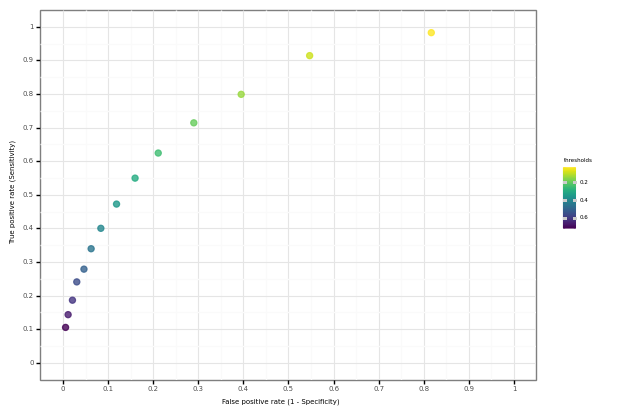

<ggplot: (143128835747)>

In [426]:
#thresholds low on top instead of high
ggplot(tpr_fpr_for_thresholds, aes(x = 'false_positive_rates', y = 'true_positive_rates', color='thresholds'))\
        + labs(x = "False positive rate (1 - Specificity)", y = "True positive rate (Sensitivity)")\
        + geom_point(size=2, alpha=0.8) + scale_color_continuous(trans = 'reverse')\
        + scale_x_continuous(limits=(0,1), breaks = seq(0, 1.01, by = 0.1))\
        + scale_y_continuous(limits=(0,1), breaks = seq(0, 1.01, by = 0.1))\
        + theme_bw()\
        +theme(legend_position="right",
            axis_text=element_text(size=5),
            axis_title=element_text(size=5),
            legend_text = element_text(size = 4),
            legend_title = element_text(size = 4),
            legend_key_size=6)
#save figure

Text(0, 0.5, 'True Positive Rate or (Sensitivity)')

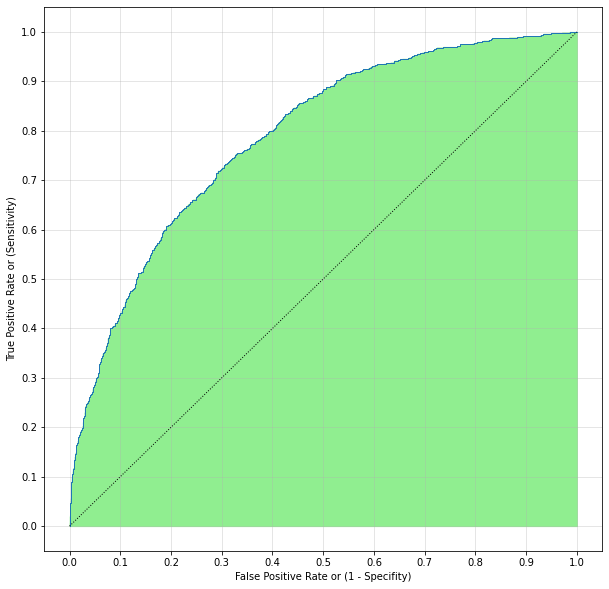

In [497]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_holdout, logit_predicted_probabilities_holdout)
#roc_auc = auc(y_holdout, logit_predicted_probabilities_holdout)
plt.figure(figsize=(10,10))
plt.xticks(np.arange(0,1.001,0.1))
plt.yticks(np.arange(0,1.001,0.1))
plt.grid(axis='y', alpha=.4)
plt.grid(axis='x', alpha=.4)
# Plot ROC curve
plt.plot(fpr, tpr, linewidth=1 )
plt.fill_between(fpr,tpr, color = 'lightgreen')
plt.plot([0, 1], [0, 1], color='black',linestyle=':',linewidth=1)  # random predictions curve
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')

In [516]:
# Confusion table with different tresholds ----------------------------------------------------------

# default: the threshold 0.5 is used to convert probabilities to binary classes
logit_class_prediction = glm_model.predict(data_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0],' (no default): ',counts[0])
print(values[1],' (default): ',counts[1])

0  (no default):  3447
1  (default):  360


In [524]:
# confusion matrix: summarize different type of errors and successfully predicted cases
# positive = "yes": explicitly specify the positive case
cm1 = confusion_matrix(y_holdout, logit_class_prediction, labels=[0,1])
cmt1df = pd.DataFrame(cm1, 
    index=['Actul no defaul', 'Actual default'], 
    columns=['Predicted no default', 'Predicted default'])
cmt1df

,Predicted no default,Predicted default
Actul no defaul,2877,140
Actual default,570,220


In [526]:
# we can apply different thresholds

# 0.5 same as before
holdout_prediction = np.where(logit_predicted_probabilities_holdout < 0.5, 0, 1)
cm_object1b = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
cm1b = pd.DataFrame(cm_object1b, 
    index=['Actul no defaul', 'Actual default'], 
    columns=['Predicted no default', 'Predicted default'])
cm1b

,Predicted no default,Predicted default
Actul no defaul,2877,140
Actual default,570,220


In [528]:
# a sensible choice: mean of predicted probabilities
mean_predicted_default_prob = np.mean(logit_predicted_probabilities_holdout)
mean_predicted_default_prob

0.20809027288854348

In [530]:
holdout_prediction = np.where(logit_predicted_probabilities_holdout < mean_predicted_default_prob, 0, 1)
cm_object2 = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
cm2 = pd.DataFrame(cm_object2, 
    index=['Actul no defaul', 'Actual default'], 
    columns=['Predicted no default', 'Predicted default'])
cm2

,Predicted no default,Predicted default
Actul no defaul,2188,829
Actual default,245,545
